In [1]:
%load_ext autoreload
%autoreload 2

import os
import h5py
import tqdm
import helpers
import warnings
import numpy as np 
from copy import copy
import pylab as plt
from os.path import join
from scipy import signal
from copy import deepcopy
from vbi.utility import kop
from multiprocessing import Pool
from scipy.signal import hilbert
from vbi.Models.St_Lan_swig import Stuart_Landau

warnings.filterwarnings("ignore")


In [2]:
data_path = "output"
if not os.path.exists(data_path):
    os.makedirs(data_path)

In [3]:
data_path = "output"
if not os.path.exists(data_path):
    os.makedirs(data_path)

def load_mat(mat_filename, key):
    with h5py.File(mat_filename, 'r') as f:
        return np.array(f[key])


# conn_path = "/home/ziaee/projects/02_Peirpaolo/dataset/data"
# DS = P_Dataset(conn_path)
# SC, Dist =  DS.load_SC("control", 1, normalize=True)
# Dist /= 1000.0 # convert to meters
# SC, Dist = DS.get_avg_SC("control", normalize=True)
# Dist /= 1000.0
SC = load_mat("data/test_conn.mat", "test_conn")
Dist = load_mat("data/test_dist.mat", "test_dist") / 1000.0


np.fill_diagonal(SC, 0.0)
SC = SC/np.max(SC)
SC = np.abs(SC)
assert(np.trace(SC) == 0.0)
num_nodes = SC.shape[0]

freq = 40.0
omega = 2*np.pi*freq * np.ones(num_nodes)

SC = SC * 2.0
# substitute zeros with average
# SC = np.where(SC<1e-10, SC_avg, SC)
# Dist = np.where(Dist<1e4, Dist_avg, Dist)

In [4]:
# plt.imshow(Dist)
# plt.colorbar()

In [5]:
# fig, ax = plt.subplots(1, 2, figsize=(6, 3))
# ax[0].hist(SC.flatten(), bins=100, range=(0.01, 1.0));
# ax[1].hist(DL.flatten(), bins=100, range=(0.01, 0.25));

In [6]:
parameters = {
    "G": 1000.0,                      # global coupling strength
    "a": -5.0,                     # biforcatio parameter
    "dt": 1e-4,                    # time step [s]
    'sigma_r': 1e-4,               # noise strength
    'sigma_v': 1e-4,               # noise strength
    'omega': omega,                # natural frequency [Hz]
    "fix_seed": 0,
    "velocity": 6.0,               # velocity          [m/s]

    "t_initial": 0.0,              # initial time    [s] 
    "t_transition": 5.0,           # transition time [s]
    "t_final": 15.0,               # end time        [s]   
    "method": "euler",

    "control": ["G", "velocity"],  # control parameters

    "adj": SC,                     # weighted connection matrix
    "distances": Dist,                  # distance matrix
    "record_step": 1,              # sampling every n step from mpr time series
    "data_path": "output",         # output directory
    "RECORD_TS": 0,                # true to store large time series in file
}


In [7]:
import json 
import torch
import sbi.utils as utils
import multiprocessing as mp
from vbi.utility import brute_sample
from vbi.Models.St_Lan import Inference
from vbi.feature_extraction import Features

BRUTE = True
NSTEPX = 60
NSTEPY = 55
N_JOBS = 10
NUM_ENSEMBLES = 1
NUM_SIMULATIONS = (NSTEPX * NSTEPY)

prior_PAR_min = [800.0, 1.0]
prior_PAR_max = [1700.0, 20.0]

fs = 1.0/(parameters["dt"]*parameters["record_step"])
# opts = {"fmax":fmax, "fmin":fmin, "normalize": False}

prior_dist = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_PAR_min),
    high=torch.as_tensor(prior_PAR_max))

sol = Inference(parameters)
theta = brute_sample(prior_dist,
                     NUM_SIMULATIONS,
                     NSTEPX,
                     NSTEPY,
                     NUM_ENSEMBLES)



In [8]:
def f_features(params, par):

    data_path = params['data_path']
    _par = deepcopy(params)

    fmin = 6.0
    fmax = 13.0

    sol = Stuart_Landau(_par)
    data = sol.simulate(par)

    fs = 1/(parameters['dt']*parameters['record_step'])

    freq, pxx = signal.welch(data['x'], fs=fs, nperseg=data['x'].shape[1]//2)
    idx = np.where((freq >= 0.0) & (freq <= 50.0))[0]
    pxx = pxx[:, idx]
    freq = freq[idx]
    pxx_avg = np.mean(pxx, axis=0)
    ind = np.argmax(pxx_avg)

    pwr = np.median(pxx, axis=0)
    ind_m = np.argmax(pwr)
    
    ## integrate under area between fmin and fmax
    idx = np.logical_and(freq >= fmin, freq <= fmax).tolist()
    area_avg = np.trapz(pxx_avg[idx], freq[idx])
    area_med = np.trapz(pwr[idx], freq[idx])

    return freq[ind_m], pwr[ind_m], area_med, freq[ind], pxx_avg[ind], area_avg

In [9]:
def batch_run(parameters, par_list):
    
    num_simulations = len(par_list)

    def update_bar(_):
        pbar.update()

    with Pool(processes=N_JOBS) as pool:
        with tqdm.tqdm(total=num_simulations) as pbar:
            async_results = [pool.apply_async(f_features, args=(parameters,
                                                                 par_list[i]),
                                              callback=update_bar)
                             for i in range(num_simulations)]
            data = [async_result.get() for async_result in async_results]

    return data


In [10]:
par_list = []
for i in range(theta.shape[0]):
    par = [theta[i, 0].item(), theta[i, 1].item()]
    par_list.append(par)
num_simulations = len(theta)
print(len(par_list))

3300


In [11]:
# data = batch_run(parameters, par_list)

100%|██████████| 3300/3300 [33:56<00:00,  1.62it/s] 


In [12]:
# len(data), len(data[0])

In [13]:
# print(f_features(parameters, par_list[0]))

In [11]:
low = np.asarray(prior_dist.base_dist.low.tolist())
high = np.asarray(prior_dist.base_dist.high.tolist())
interval = np.abs(high - low)
x = [low[0] + i/NSTEPX * interval[0] for i in range(NSTEPX)]
y = [low[1] + j/NSTEPY * interval[1] for j in range(NSTEPY)]

In [15]:
x = theta[:, 0].numpy()
y = theta[:, 1].numpy()
F_MED = np.array([data[i][0] for i in range(num_simulations)]).reshape((NUM_ENSEMBLES, NSTEPX, NSTEPY))
P_MED = np.array([data[i][1] for i in range(num_simulations)]).reshape((NUM_ENSEMBLES, NSTEPX, NSTEPY))
AREA_MED = np.array([data[i][2] for i in range(num_simulations)]).reshape((NUM_ENSEMBLES, NSTEPX, NSTEPY))
F_MAX = np.array([data[i][3] for i in range(num_simulations)]).reshape((NUM_ENSEMBLES, NSTEPX, NSTEPY))
P_MAX = np.array([data[i][4] for i in range(num_simulations)]).reshape((NUM_ENSEMBLES, NSTEPX, NSTEPY))
AREA_MAX = np.array([data[i][5] for i in range(num_simulations)]).reshape((NUM_ENSEMBLES, NSTEPX, NSTEPY))


In [16]:
f_avg = np.nanmean(F_MAX, axis=0)
p_avg = np.nanmean(P_MAX, axis=0)
a_avg = np.nanmean(AREA_MAX, axis=0)

f_med = np.nanmedian(F_MED, axis=0)
p_med = np.nanmedian(P_MED, axis=0)
a_med = np.nanmedian(AREA_MED, axis=0)

f_avg.shape, p_avg.shape, a_avg.shape, f_med.shape, p_med.shape, a_med.shape

((60, 55), (60, 55), (60, 55), (60, 55), (60, 55), (60, 55))

In [17]:
np.savez(join(data_path, "data_avg"),
         x=x,
         y=y,
         f_avg=f_avg,
         p_avg=p_avg,
         a_avg=a_avg,
         f_med=f_med,
         p_med=p_med,
         a_med=a_med)


In [12]:
data = np.load(join(data_path, "data_avg.npz"))
x = data['x']
y = data['y']
f_avg = data['f_avg']
p_avg = data['p_avg']
a_avg = data['a_avg']
f_med = data['f_med']
p_med = data['p_med']
a_med = data['a_med']


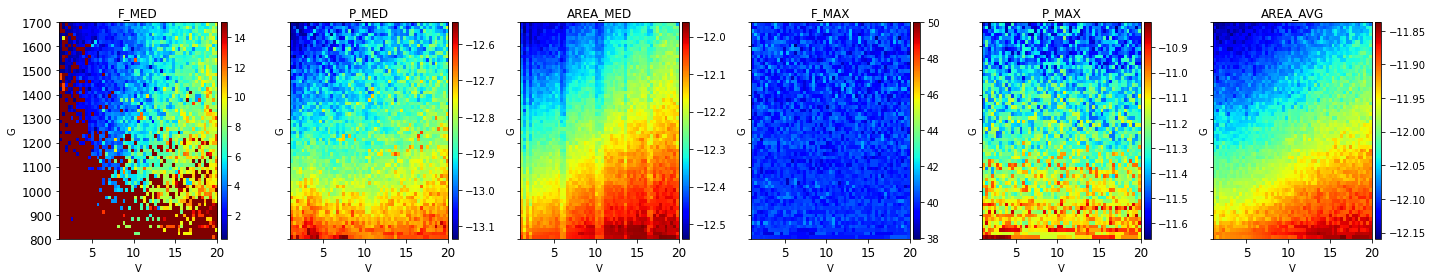

In [20]:
from copy import copy

fig, ax = plt.subplots(1, 6, figsize=(20, 4), sharey=True)
helpers.plot_matrix(f_med, ax[0], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="F_MED", vmax=15)
helpers.plot_matrix(np.log10(p_med), ax[1], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="P_MED")
helpers.plot_matrix(np.log10(a_med), ax[2], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="AREA_MED")
helpers.plot_matrix(f_avg, ax[3], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="F_MAX", vmax=50)
helpers.plot_matrix(np.log10(p_avg), ax[4], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="P_MAX")
helpers.plot_matrix(np.log10(a_avg) , ax[5], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="AREA_AVG")
plt.tight_layout()
plt.savefig(join(data_path, "fig.png"), dpi=300)


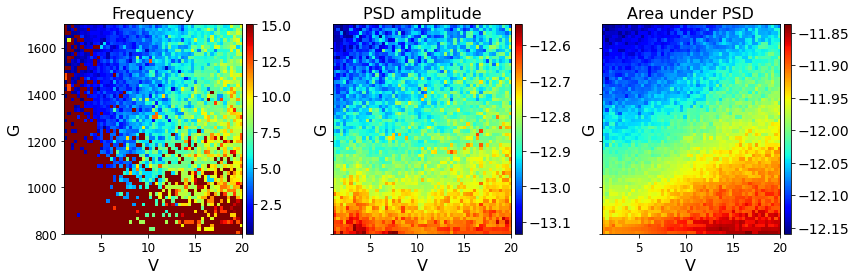

In [13]:
from copy import copy

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
helpers.plot_matrix(f_med, ax[0], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="Frequency", vmax=15)
helpers.plot_matrix(np.log10(p_med), ax[1], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="PSD amplitude")
helpers.plot_matrix(np.log10(a_avg), ax[2], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="Area under PSD")
# helpers.plot_matrix(f_avg, ax[3], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="F_MAX", vmax=50)
# helpers.plot_matrix(np.log10(p_avg), ax[4], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="P_MAX")
# helpers.plot_matrix(np.log10(a_avg) , ax[5], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="AREA_AVG")
plt.tight_layout()


plt.savefig(join(data_path, "fig.png"), dpi=300)
plt.savefig(join(data_path, "fig.svg"))
